# Data and methodology of Machine Learning 

Mathurin Massias, mathurin.massias@inria.fr

Material taken from the Euroscipy 2019 scikit-learn tutorial by Loic Esteve and Olivier Grisel.

Today we will build our first Machine Learning pipeline, from dataloading to prediction through feature extraction and hyperparameter tuning.

In this notebook, we will look at necessary steps that happen before any machine learning takes place. 
* load the data
* look at the variables in the dataset, in particular make the difference
  between numerical and categorical variables, which need different
  preprocessing in most machine learning workflows
* visualize the distribution of the variables to gain some insights into the dataset.

In [1]:
import pandas as pd
import seaborn as sns

## Loading the adult census dataset

We will use data from the "Current Population adult_census" from 1994 that we
downloaded from [OpenML](http://openml.org/).

In [2]:
adult_census = pd.read_csv("https://www.openml.org/data/get_csv/1595261/adult-census.csv")

What does csv mean? Do you notice anything special about our use of the `pandas.read_csv` function?

We can look at the OpenML webpage to know more about this dataset: https://www.openml.org/d/1590

## Look at the variables in the dataset
The data are stored in a pandas dataframe.

In [3]:
adult_census.head()

age   workclass  fnlwgt      education  education-num       marital-status  \
0   25     Private  226802           11th              7        Never-married   
1   38     Private   89814        HS-grad              9   Married-civ-spouse   
2   28   Local-gov  336951     Assoc-acdm             12   Married-civ-spouse   
3   44     Private  160323   Some-college             10   Married-civ-spouse   
4   18           ?  103497   Some-college             10        Never-married   

           occupation relationship    race      sex  capital-gain  \
0   Machine-op-inspct    Own-child   Black     Male             0   
1     Farming-fishing      Husband   White     Male             0   
2     Protective-serv      Husband   White     Male             0   
3   Machine-op-inspct      Husband   Black     Male          7688   
4                   ?    Own-child   White   Female             0   

   capital-loss  hours-per-week  native-country   class  
0             0              40   United-States   <=50K  
1             0              50   United-States   <=50K  
2             0              40   United-States    >50K  
3             0              40   United-States    >50K  
4             0              30   United-States   <=50K

The column named **class** is our target variable (i.e., the variable which
we want to predict). The two possible classes are `<= 50K` (low-revenue) and
`> 50K` (high-revenue).

What type of data do we have? And which problem are we considering? Can you envision practical usecases of this dataset?

In [4]:
adult_census.shape

(48842, 15)

In [5]:
target_column = 'class'
adult_census[target_column].value_counts()

class
<=50K    37155
>50K     11687
Name: count, dtype: int64

Note: classes are slighly imbalanced. Class imbalance happens often in
practice and may need special techniques for machine learning. For example in
a medical setting, if we are trying to predict whether patients will develop
a rare disease, there will be a lot more sane patients than ill patients in
the dataset.

To handle imbalanced data:
* Package for imbalanced data: https://imbalanced-learn.org/stable/
* To split the data set with the same proportions from my data: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* Can use weighted loss to mitigate the unbalanced data (equivalent to upsample the data since you have duplicates which will therefore have double weight)

The dataset contains both numerical and categorical data. Numerical values
can take continuous values, for example `age`. Categorical values can have a
finite number of values, for exemple `native-country`.

In practice, `age` takes a finite number of values in the dataset. Yet, how is
it different from a categorical value?
* The numerical features have a sense of distance between them, while cathegorical variables do not.

In [6]:
numerical_columns = ['age', 'education-num', 'capital-gain', 'capital-loss',
                     'hours-per-week']
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
all_columns = numerical_columns + categorical_columns + [target_column]

adult_census = adult_census[all_columns]

In [7]:
adult_census

age  education-num  capital-gain  capital-loss  hours-per-week  \
0       25              7             0             0              40   
1       38              9             0             0              50   
2       28             12             0             0              40   
3       44             10          7688             0              40   
4       18             10             0             0              30   
...    ...            ...           ...           ...             ...   
48837   27             12             0             0              38   
48838   40              9             0             0              40   
48839   58              9             0             0              40   
48840   22              9             0             0              20   
48841   52              9         15024             0              40   

           workclass      education       marital-status          occupation  \
0            Private           11th        Never-married   Machine-op-inspct   
1            Private        HS-grad   Married-civ-spouse     Farming-fishing   
2          Local-gov     Assoc-acdm   Married-civ-spouse     Protective-serv   
3            Private   Some-college   Married-civ-spouse   Machine-op-inspct   
4                  ?   Some-college        Never-married                   ?   
...              ...            ...                  ...                 ...   
48837        Private     Assoc-acdm   Married-civ-spouse        Tech-support   
48838        Private        HS-grad   Married-civ-spouse   Machine-op-inspct   
48839        Private        HS-grad              Widowed        Adm-clerical   
48840        Private        HS-grad        Never-married        Adm-clerical   
48841   Self-emp-inc        HS-grad   Married-civ-spouse     Exec-managerial   

      relationship    race      sex  native-country   class  
0        Own-child   Black     Male   United-States   <=50K  
1          Husband   White     Male   United-States   <=50K  
2          Husband   White     Male   United-States    >50K  
3          Husband   Black     Male   United-States    >50K  
4        Own-child   White   Female   United-States   <=50K  
...            ...     ...      ...             ...     ...  
48837         Wife   White   Female   United-States   <=50K  
48838      Husband   White     Male   United-States    >50K  
48839    Unmarried   White   Female   United-States   <=50K  
48840    Own-child   White     Male   United-States   <=50K  
48841         Wife   White   Female   United-States    >50K  

[48842 rows x 14 columns]

Note that for simplicity, we have ignored the "fnlwgt" (final weight) column
that was crafted by the creators of the dataset when sampling the dataset to
be representative of the full census database.

## Inspect the data
Before building a machine learning model, it is a good idea to look at the
data:
* maybe the task you are trying to achieve can be solved without machine
  learning
* you need to check that the data you need for your task is indeed present in
the dataset
* inspecting the data is a good way to find peculiarities. These can can
  arise in the data collection (for example, malfunctioning sensor or missing
  values), or the way the data is processed afterwards (for example capped
  values).

Let's look at the distribution of individual variables, to get some insights
about the data. We can start by plotting histograms.

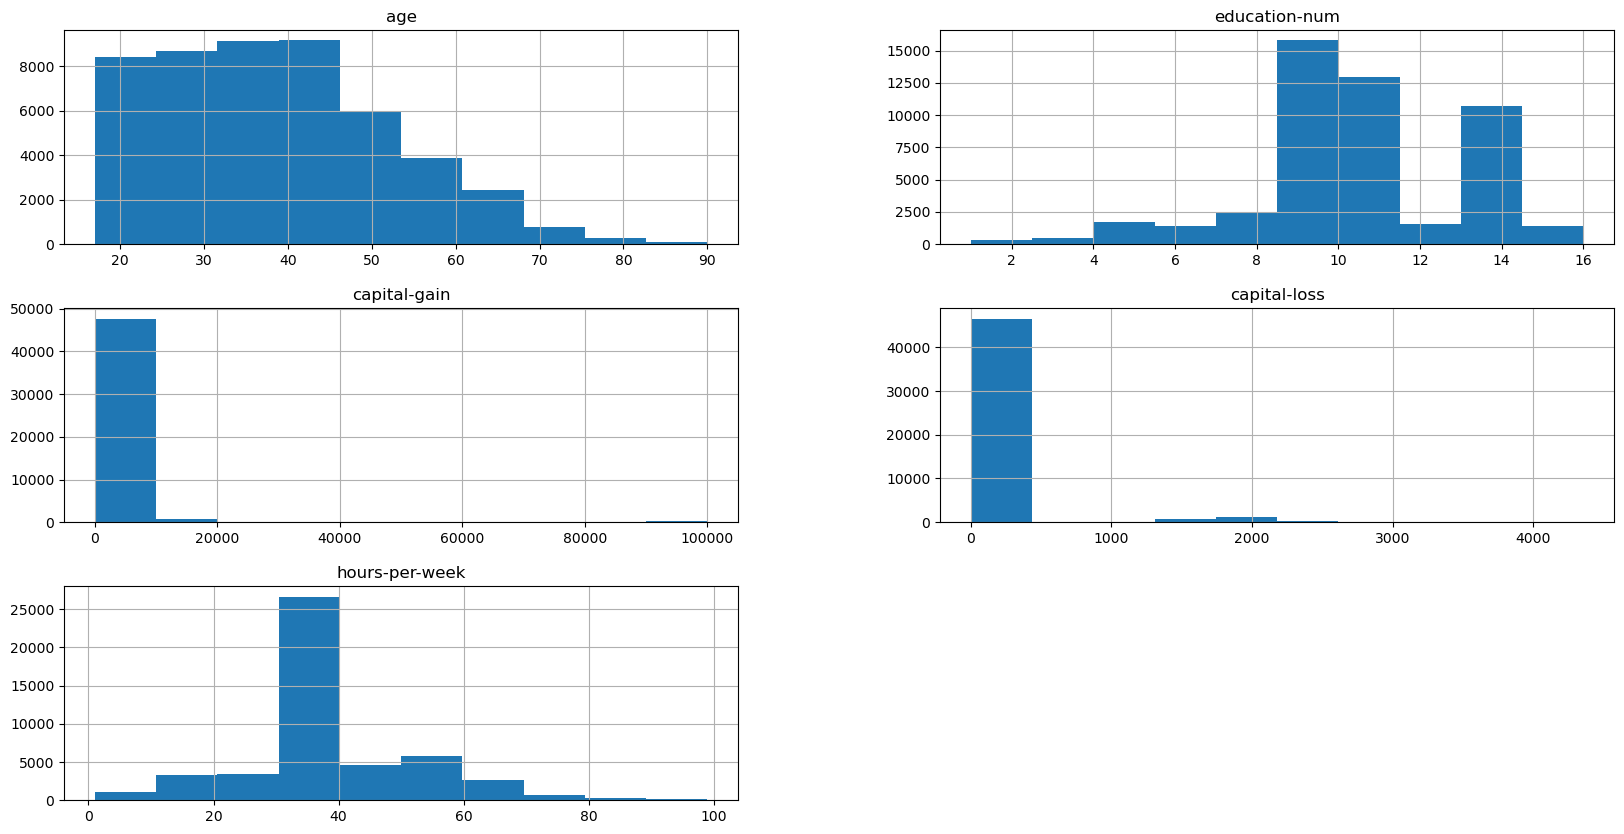

In [8]:
adult_census.hist(figsize=(20, 10));  # What did pandas do? Only the pd.dtypes is a number that will be ploted since it makes no sense to do it with the cathegorical variables

We can already make a few comments about some of the variables:
* age: there are not that many points for 'age > 70'. The dataset description
does indicate that retired people have been filtered out (`hours-per-week > 0`).
* education-num: peak at 10 and 13, hard to tell what it corresponds to
without looking much further. We'll do that later in this notebook.
* hours per week at 40, this was very likely the standard of working hours at
the time of the data collection
* most values of capital-gain and capital-loss are close to zero

For categorical variables, we can look at the distribution of values:

In [9]:
adult_census['sex'].value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

In [10]:
adult_census['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

What's the issue with the approach we've adopted so far?

`ydata_profiling` is a nice tool to automate the data inspection (both for numerical and
categorical variables).

In [11]:
!pip install -U ydata_profiling # -U is to accept by default the questions of the terminal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ydata_profiling
    Found existing installation: ydata-profiling 4.11.0
    Uninstalling ydata-profiling-4.11.0:
      Successfully uninstalled ydata-profiling-4.11.0


In [12]:
import ydata_profiling
adult_census.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

As noted above, `education-num` distribution has two clear peaks around 10
and 13. It would be reasonable to expect that 'education-num' is the number of
years of education. Let's look at the relationship between education and
education-num.

In [13]:
pd.crosstab(index=adult_census['education'], columns=adult_census['education-num'])

education-num  1    2    3    4    5     6     7    8      9      10    11  \
education                                                                    
10th            0    0    0    0    0  1389     0    0      0      0     0   
11th            0    0    0    0    0     0  1812    0      0      0     0   
12th            0    0    0    0    0     0     0  657      0      0     0   
1st-4th         0  247    0    0    0     0     0    0      0      0     0   
5th-6th         0    0  509    0    0     0     0    0      0      0     0   
7th-8th         0    0    0  955    0     0     0    0      0      0     0   
9th             0    0    0    0  756     0     0    0      0      0     0   
Assoc-acdm      0    0    0    0    0     0     0    0      0      0     0   
Assoc-voc       0    0    0    0    0     0     0    0      0      0  2061   
Bachelors       0    0    0    0    0     0     0    0      0      0     0   
Doctorate       0    0    0    0    0     0     0    0      0      0     0   
HS-grad         0    0    0    0    0     0     0    0  15784      0     0   
Masters         0    0    0    0    0     0     0    0      0      0     0   
Preschool      83    0    0    0    0     0     0    0      0      0     0   
Prof-school     0    0    0    0    0     0     0    0      0      0     0   
Some-college    0    0    0    0    0     0     0    0      0  10878     0   

education-num    12    13    14   15   16  
education                                  
10th              0     0     0    0    0  
11th              0     0     0    0    0  
12th              0     0     0    0    0  
1st-4th           0     0     0    0    0  
5th-6th           0     0     0    0    0  
7th-8th           0     0     0    0    0  
9th               0     0     0    0    0  
Assoc-acdm     1601     0     0    0    0  
Assoc-voc         0     0     0    0    0  
Bachelors         0  8025     0    0    0  
Doctorate         0     0     0    0  594  
HS-grad           0     0     0    0    0  
Masters           0     0  2657    0    0  
Preschool         0     0     0    0    0  
Prof-school       0     0     0  834    0  
Some-college      0     0     0    0    0

This shows that education and education-num are redundant. For
example, `education-num=2` is equivalent to `education='1st-4th'`. In
practice that means we can remove `education-num` without losing information.
Note that having redundant (or highly correlated) columns can be a problem
for machine learning algorithms.

Another way to inspect the data is to do a pairplot and show how variable
differ according to the class. In the diagonal you can see the distribution
of individual variables. The plots on the off-diagonal can reveal interesting
interactions between variables.

In the snippet below, what is the purpose of `n_samples_to_plot`? 
What's the advantage? What's the risk? How can we circumvent it?
- readability and you might just look at a paerrt of your data if it is not randomized

---
pd.sample(3): get a random sample of your data set but if you do not provide the seed, it will give you q different result everytime you run it.
- Your computer has a list of pre determined "random" numbers and the seed sets the cursor, when you call np.random.randn(n) you move the cursor by n, if you call again np.random.randn(n) you advance the coursor again by n and if you run np.random.seed() you reset the cursor.

In [14]:
import numpy as np

In [15]:
np.random.seed(1)
np.random.randn(5)

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763])

In [16]:
np.random.randn(5)

array([-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038])

In [17]:
np.random.seed(1)
np.random.randn(10)

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038])

---

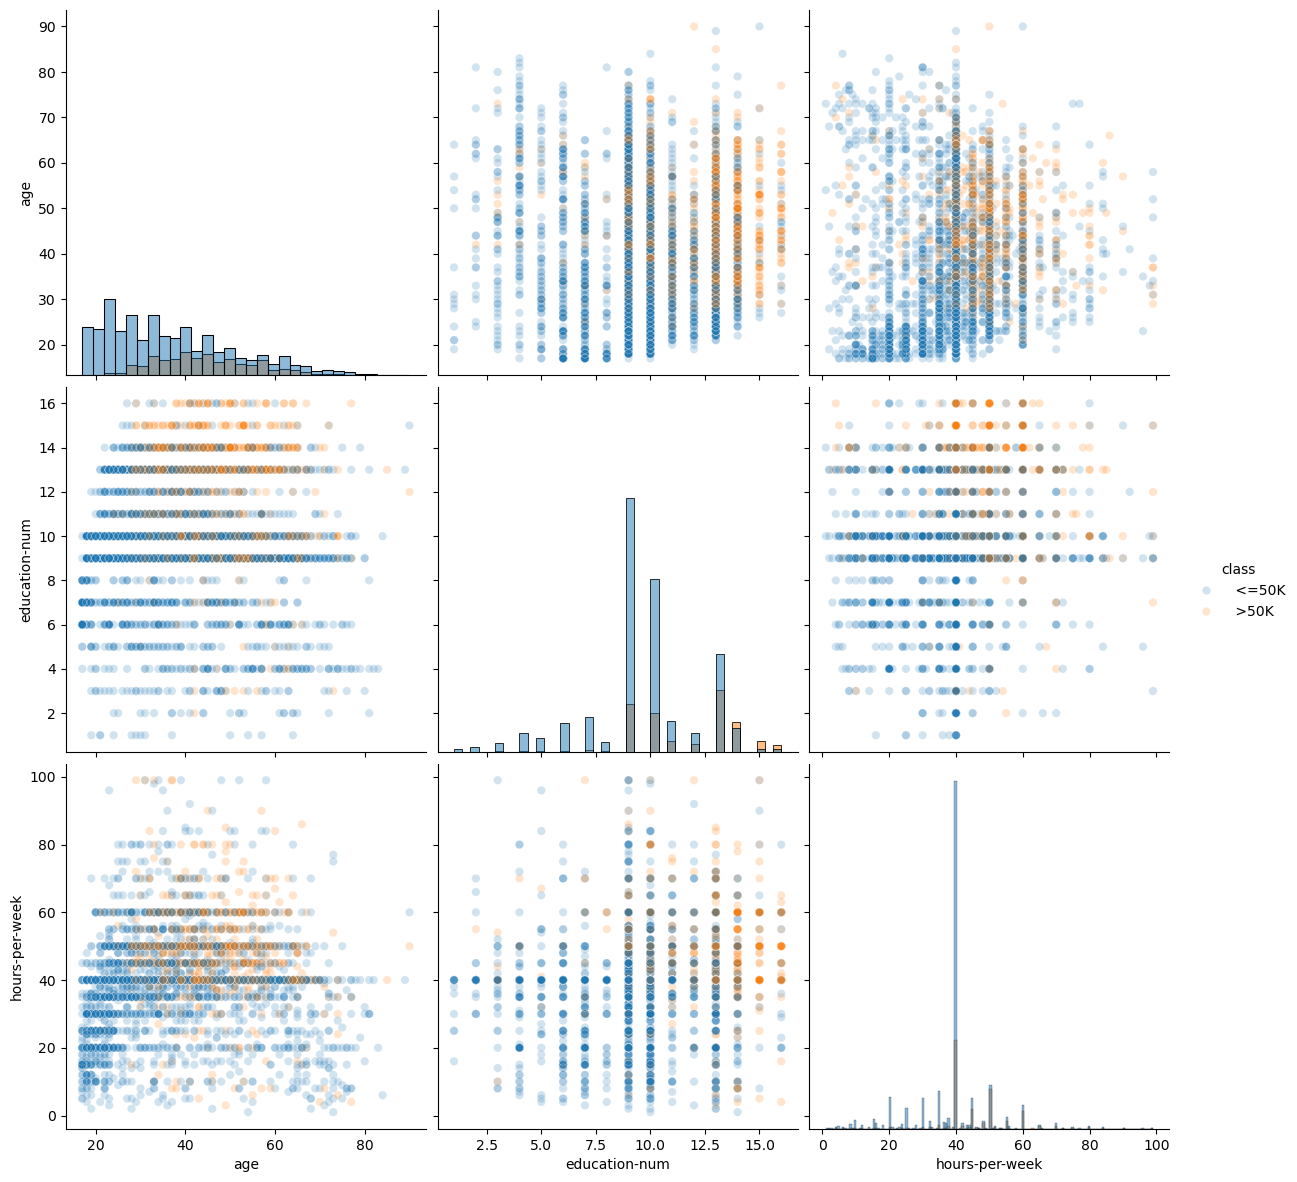

In [18]:
n_samples_to_plot = 5000
columns = ['age', 'education-num', 'hours-per-week']
sns.pairplot(data=adult_census[0:n_samples_to_plot], vars=columns,
             hue=target_column, plot_kws={'alpha': 0.2}, height=4,
             diag_kind='hist'); #seaborn makes better graphs, built on matplotlib

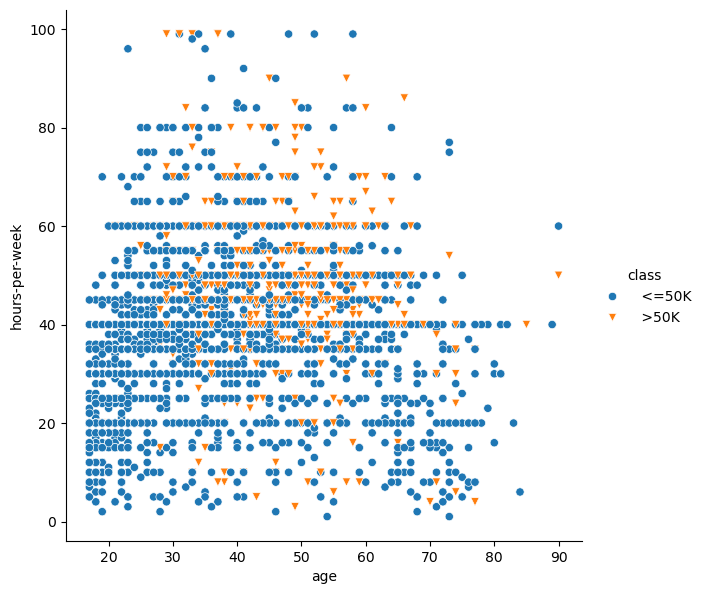

In [19]:
sns.pairplot(data=adult_census[:n_samples_to_plot], x_vars='age', y_vars='hours-per-week',
             hue=target_column, markers=['o', 'v'], height=6)


By looking at the data you could infer some hand-written rules to predict the
class:
* if you are young (less than 25 year-old roughly), you are in the `<= 50K` class.
* if you are old (more than 70 year-old roughly), you are in the `<= 50K` class.
* if you work part-time (less than 40 hours roughly) you are in the `<= 50K` class.

These hand-written rules could work reasonably well without the need for any
machine learning. Note however that it is not very easy to create rules for
the region `40 < hours-per-week < 60` and `30 < age < 70`. We can hope that
machine learning can help in this region. Also note that visualization can
help creating hand-written rules but is limited to 2 dimensions (maybe 3
dimensions), whereas machine learning models can build models in
high-dimensional spaces.

Another thing worth mentioning in this plot: if you are young (less than 25
year-old roughly) you tend to work less and if you are old (more than 70
year-old roughly). This is a non-linear relationship between age and hours
per week. **Some machine learning models can only capture linear interaction so
this may be a factor when deciding which model to chose.**

In a machine-learning setting, we will use an algorithm to automatically
decide what should be the "rules" in order to predict on new data. We can
check which set of simple rule a decision tree would grasp using the same
data.

In [20]:
def plot_tree_decision_function(tree, X, y, ax):
    """Plot the different decision rules found by a `DecisionTreeClassifier`.

    Parameters
    ----------
    tree : DecisionTreeClassifier instance
        The decision tree to inspect.
    X : dataframe of shape (n_samples, n_features)
        The data used to train the `tree` estimator.
    y : ndarray of shape (n_samples,)
        The target used to train the `tree` estimator.
    ax : matplotlib axis
        The matplotlib axis where to plot the different decision rules.
    """
    import numpy as np
    from scipy import ndimage

    h = 0.02
    x_min, x_max = 0, 100
    y_min, y_max = 0, 100
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
    )

    Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    faces = tree.tree_.apply(
        np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    )
    faces = faces.reshape(xx.shape)
    border = ndimage.laplace(faces) != 0
    ax.scatter(
        X.iloc[:, 0], X.iloc[:, 1], c=np.array(['tab:blue', 'tab:red'])[y],
        s=60, alpha=0.7
    )
    ax.contourf(xx, yy, Z, alpha=.4, cmap='RdBu_r')
    ax.scatter(xx[border], yy[border], marker='.', s=1)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    sns.despine(offset=10)

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)  # reset the plotting style

In [22]:
from sklearn.preprocessing import LabelEncoder

# select a subset of data
data_subset = adult_census[:n_samples_to_plot]
X = data_subset[["age", "hours-per-week"]]
y = LabelEncoder().fit_transform(data_subset[target_column].to_numpy())


In [23]:
y 

array([0, 0, 1, ..., 0, 1, 1])

In [24]:
data_subset[target_column]

0        <=50K
1        <=50K
2         >50K
3         >50K
4        <=50K
         ...  
4995     <=50K
4996     <=50K
4997     <=50K
4998      >50K
4999      >50K
Name: class, Length: 5000, dtype: object

We will create a decision tree which we will keep really simple on purpose.
We will only allow a maximum of 2 rules to interpret the results.

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

max_leaf_nodes = 3
tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0) # normaly 

tree.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

We can now first check the set of rules learnt by the tree and check
visually what theses rules look like.

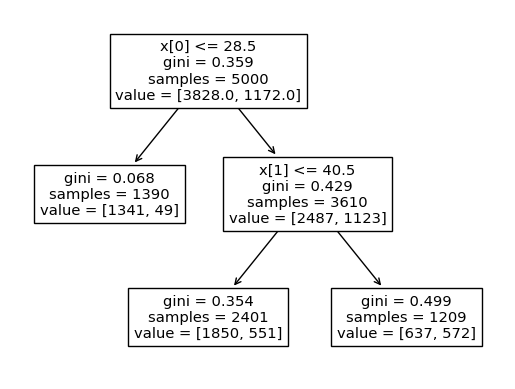

In [26]:
# plot the tree structure
fig, ax = plt.subplots()
plot_tree(tree, ax=ax)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


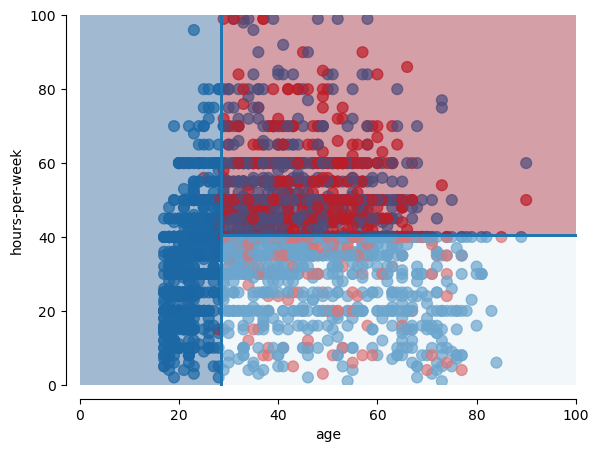

In [27]:
# plot the decision function learned by the tree
fig, ax = plt.subplots()
plot_tree_decision_function(tree, X, y, ax=ax)
plt.show()

Allowing only 3 leaves in the tree, we get similar rules than the one
designed by hand:
* the persons younger than 28.5 year-old will be considered in the class
  earning `<= 50K`.
* the persons older than 28.5 and working more than 40.5 hours-per-week
  will be considered in the class earning `> 50K`, while the one working
  below 40.5 hours-per-week, will be considered in the class
  earning `<= 50K`.


So far we have:
* loaded the data from a CSV file using `pandas`
* looked at the kind of variables in the dataset, and make the difference
  between categorical and numerical variables.
* inspected the data with `pandas`, `seaborn` and `ydata_profiling`. Data inspection
  can allow you to decide whether using machine learning is appropriate for
  your data and to notice potential peculiarities in your data.
  
**Let's move to more advanced model fitting**

In [28]:
target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=[target_name])

In [29]:
print(
    f"The dataset contains {data.shape[0]} samples and {data.shape[1]} "
    "features"
)

The dataset contains 48842 samples and 13 features


Let's check again the type of data we have: 

In [30]:
data.dtypes

age                int64
education-num      int64
capital-gain       int64
capital-loss       int64
hours-per-week     int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
native-country    object
dtype: object

In [31]:
import numpy as np
data_numeric = data.select_dtypes(include=np.number)

In [32]:
data_numeric

age  education-num  capital-gain  capital-loss  hours-per-week
0       25              7             0             0              40
1       38              9             0             0              50
2       28             12             0             0              40
3       44             10          7688             0              40
4       18             10             0             0              30
...    ...            ...           ...           ...             ...
48837   27             12             0             0              38
48838   40              9             0             0              40
48839   58              9             0             0              40
48840   22              9             0             0              20
48841   52              9         15024             0              40

[48842 rows x 5 columns]

We're going to train various models. How can we choose the best? 
- choice of metric (here OK: classification)
- applied to what?

In [33]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, random_state=2406,
)

print(
    f"The training dataset contains {data_train.shape[0]} samples and "
    f"{data_train.shape[1]} features"
)
print(
    f"The testing dataset contains {data_test.shape[0]} samples and "
    f"{data_test.shape[1]} features"
)

The training dataset contains 36631 samples and 5 features
The testing dataset contains 12211 samples and 5 features


We will build a linear classification model called "Logistic Regression". The
`fit` method is called to train the model from the input and target data. Only
the training data should be given for this purpose.

In addition, when checking the time required to train the model and internally
check the number of iterations done by the solver to find a solution.

In [34]:
from sklearn.linear_model import LogisticRegression # LogisticRegression is a classification model and not a regression model
import time

model = LogisticRegression(solver='lbfgs')
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

print(
    f"The model {model.__class__.__name__} was trained in "
    f"{elapsed_time:.3f} seconds for {model.n_iter_} iterations"
)

The model LogisticRegression was trained in 0.172 seconds for [92] iterations


In [35]:
target_predicted = model.predict(data_test)  # predict on test data

predictions = data_test.copy()
predictions['predicted-class'] = target_predicted
predictions['true-class'] = target_test
predictions['correct'] = target_predicted == target_test
predictions.head(n=10)

age  education-num  capital-gain  capital-loss  hours-per-week  \
40293   26             10             0             0              40   
29873   21             10             0             0              35   
33265   75              9          2653             0              14   
34878   59              9             0             0              40   
41669   27              9             0             0              15   
3413    44             10             0             0              50   
29466   39              9             0             0              60   
45011   55             10             0          2258              62   
6655    49             13             0             0              60   
19005   45             13          4934             0              50   

      predicted-class true-class  correct  
40293           <=50K      <=50K     True  
29873           <=50K      <=50K     True  
33265           <=50K      <=50K     True  
34878           <=50K       >50K    False  
41669           <=50K      <=50K     True  
3413            <=50K      <=50K     True  
29466           <=50K       >50K    False  
45011            >50K       >50K     True  
6655             >50K       >50K     True  
19005            >50K       >50K     True

In [36]:
print(
    f"The test accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.5f}"
)

The test accuracy using a LogisticRegression is 0.81205


In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(data_test), target_test)

0.8120547047743838

In [38]:
(' <=50K' == target_test).mean()

0.7600524117598886

In [39]:
from sklearn.dummy import DummyClassifier # To have a baseline so that you can see if the accuracy of your model is good or not (above baseline is good)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(data_train, target_train)
dummy.score(data_train, target_train)

0.7609401872730747

## Exercise 1

- What would be the score of a model that always predicts `' >50K'`?
- What would be the score of a model that always predicts `' <=50K'`?
- Is 81% or 82% accuracy a good score for this problem?

Hint: You can compute the cross-validated of a [DummyClassifier](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) the performance of such baselines.

In [40]:
data_train.describe()

age  education-num  capital-gain  capital-loss  hours-per-week
count  36631.000000   36631.000000  36631.000000  36631.000000    36631.000000
mean      38.641315      10.089569   1061.344026     88.049657       40.467992
std       13.685046       2.566841   7303.192428    404.060060       12.401930
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train)  # shorthand: fit_transform
data_train_scaled

array([[-1.28911188, -0.03489509, -0.14532802, -0.21791528, -0.0377359 ],
       [-0.70452421, -0.03489509,  0.90737667, -0.21791528,  1.09113606],
       [-0.41223038, -1.59325194, -0.14532802, -0.21791528, -0.0377359 ],
       ...,
       [ 0.39157767, -0.03489509, -0.14532802, -0.21791528, -0.0377359 ],
       [ 0.46465112, -0.03489509, -0.14532802, -0.21791528, -0.0377359 ],
       [ 0.83001842, -1.98284115, -0.14532802, -0.21791528, -0.0377359 ]])

Let's have a look at the transformed data:

In [42]:
data_train_scaled = pd.DataFrame(data_train_scaled, columns=data_train.columns)
data_train_scaled.describe() # For scaled data the mean is 0 and the std is 1

age  education-num  capital-gain  capital-loss  hours-per-week
count  3.663100e+04   3.663100e+04  3.663100e+04  3.663100e+04    3.663100e+04
mean  -4.296503e-17   2.676828e-16  1.357811e-17  4.306202e-17    2.701075e-16
std    1.000014e+00   1.000014e+00  1.000014e+00  1.000014e+00    1.000014e+00
min   -1.581406e+00  -3.541198e+00 -1.453280e-01 -2.179153e-01   -3.182451e+00
25%   -7.775977e-01  -4.244843e-01 -1.453280e-01 -2.179153e-01   -3.773590e-02
50%   -1.199365e-01  -3.489509e-02 -1.453280e-01 -2.179153e-01   -3.773590e-02
75%    6.838715e-01   7.442833e-01 -1.453280e-01 -2.179153e-01    3.654327e-01
max    3.752957e+00   2.302640e+00  1.354736e+01  1.056281e+01    4.719653e+00

In [43]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [44]:
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.5f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model[-1].n_iter_} iterations"
)

The accuracy using a Pipeline is 0.81205 with a fitting time of 0.058 seconds in [10] iterations


Let's now perform 5 fold cross validation:

In [45]:
for k in range(5):
    train, test = ..., ...

Don't do as above, coding the CV yourself! 

Always look for functions already coded (in reference packages): 
- they'll be more correct than our version
- they'll be faster than our version
- they'll have nicer functionalities that we didn't know we wanted
- we'll leverage the work of many smart people that asked themselves the same question as we are asking now

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, data_numeric, target, cv=5) # add n_jobs=-1 to use as many cores as you can to paralelise your training
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.81226328 0.8096018  0.81337019 0.81337019 0.82217445]


In [47]:
print(f"The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.814 +/- 0.004


## Working with categorical variables

As we have seen in the previous section, a numerical variable is a continuous
quantity represented by a real or integer number. Those variables can be
naturally handled by machine learning algorithms that typically composed of
a sequence of arithmetic instructions such as additions and multiplications.

By opposition, categorical variables have discrete values typically represented
by string labels taken in a finite list of possible choices. For instance, the
variable `native-country` in our dataset is a categorical variable because it
encodes the data using a finite list of possible countries (along with the `?`
marker when this information is missing):

In [48]:
data["native-country"].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

In the remainder of this section, we will present different strategies to
encode categorical data into numerical data which can be used by a
machine-learning algorithm.

In [49]:
data_categorical = adult_census.select_dtypes(include=[object]).drop(columns=["class"])

In [50]:
data_categorical.head()

workclass      education       marital-status          occupation  \
0     Private           11th        Never-married   Machine-op-inspct   
1     Private        HS-grad   Married-civ-spouse     Farming-fishing   
2   Local-gov     Assoc-acdm   Married-civ-spouse     Protective-serv   
3     Private   Some-college   Married-civ-spouse   Machine-op-inspct   
4           ?   Some-college        Never-married                   ?   

  relationship    race      sex  native-country  
0    Own-child   Black     Male   United-States  
1      Husband   White     Male   United-States  
2      Husband   White     Male   United-States  
3      Husband   Black     Male   United-States  
4    Own-child   White   Female   United-States

In [51]:
print(f"The datasets is composed of {data_categorical.shape[1]} features")

The datasets is composed of 8 features


### Encoding ordinal categories

The most intuitive strategy is to encode each category with a number.
The `OrdinalEncoder` will transform the data in such manner.

In [52]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(data_categorical)
# Same as:
# encoder.fit(data_categorical) - figures the mapping
# data_encoded = encoder.transform(data_categorical) - applies the mapping

print(f"The dataset encoded contains {data_encoded.shape[1]} features")
data_encoded[:5]

The dataset encoded contains 8 features


array([[ 4.,  1.,  4.,  7.,  3.,  2.,  1., 39.],
       [ 4., 11.,  2.,  5.,  0.,  4.,  1., 39.],
       [ 2.,  7.,  2., 11.,  0.,  4.,  1., 39.],
       [ 4., 15.,  2.,  7.,  0.,  2.,  1., 39.],
       [ 0., 15.,  4.,  0.,  3.,  4.,  0., 39.]])

In [53]:
encoder.categories_ # the underscore means it's available after the fitting

[array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
        ' Unmarried'

We can see that all categories have been encoded for each feature
independently. We can also notice that the number of features before and after
the encoding is the same.

However, one has to be careful when using this encoding strategy. Using this
integer representation can lead the downstream models to make the assumption
that the categories are ordered: 0 is smaller than 1 which is smaller than 2,
etc.

By default, `OrdinalEncoder` uses a lexicographical strategy to map string
category labels to integers. This strategy is completely arbitrary and often be
meaningless. For instance suppose the dataset has a categorical variable named
"size" with categories such as "S", "M", "L", "XL". We would like the integer
representation to respect the meaning of the sizes by mapping them to increasing
integers such as 0, 1, 2, 3. However lexicographical strategy used by default
would map the labels "S", "M", "L", "XL" to 2, 1, 0, 3.

The `OrdinalEncoder` class accepts a "categories" constructor argument to pass
an the correct ordering explicitly.

If a categorical variable does not carry any meaningful order information then
this encoding might be misleading to downstream statistical models and you might
consider using one-hot encoding instead (see below).

Note however that the impact a violation of this ordering assumption is really
dependent on the downstream models (for instance linear models are much more
sensitive than models built from a ensemble of decision trees).

### Encoding nominal categories (without assuming any order)

`OneHotEncoder` is an alternative encoder that can prevent the dowstream
models to make a false assumption about the ordering of categories. For a
given feature, it will create as many new columns as there are possible
categories. For a given sample, the value of the column corresponding to the
category will be set to `1` while all the columns of the other categories will
be set to `0`.

In [54]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
data_encoded = encoder.fit_transform(data_categorical)
print(f"The dataset encoded contains {data_encoded.shape[1]} features")
data_encoded

The dataset encoded contains 102 features


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [55]:
columns_encoded = encoder.get_feature_names_out(data_categorical.columns)
pd.DataFrame(data_encoded, columns=columns_encoded).head()

workclass_ ?  workclass_ Federal-gov  workclass_ Local-gov  \
0           0.0                     0.0                   0.0   
1           0.0                     0.0                   0.0   
2           0.0                     0.0                   1.0   
3           0.0                     0.0                   0.0   
4           1.0                     0.0                   0.0   

   workclass_ Never-worked  workclass_ Private  workclass_ Self-emp-inc  \
0                      0.0                 1.0                      0.0   
1                      0.0                 1.0                      0.0   
2                      0.0                 0.0                      0.0   
3                      0.0                 1.0                      0.0   
4                      0.0                 0.0                      0.0   

   workclass_ Self-emp-not-inc  workclass_ State-gov  workclass_ Without-pay  \
0                          0.0                   0.0                     0.0   
1                          0.0                   0.0                     0.0   
2                          0.0                   0.0                     0.0   
3                          0.0                   0.0                     0.0   
4                          0.0                   0.0                     0.0   

   education_ 10th  ...  native-country_ Portugal  \
0              0.0  ...                       0.0   
1              0.0  ...                       0.0   
2              0.0  ...                       0.0   
3              0.0  ...                       0.0   
4              0.0  ...                       0.0   

   native-country_ Puerto-Rico  native-country_ Scotland  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   

   native-country_ South  native-country_ Taiwan  native-country_ Thailand  \
0                    0.0                     0.0                       0.0   
1                    0.0                     0.0                       0.0   
2                    0.0                     0.0                       0.0   
3                    0.0                     0.0                       0.0   
4                    0.0                     0.0                       0.0   

   native-country_ Trinadad&Tobago  native-country_ United-States  \
0                              0.0                            1.0   
1                              0.0                            1.0   
2                              0.0                            1.0   
3                              0.0                            1.0   
4                              0.0                            1.0   

   native-country_ Vietnam  native-country_ Yugoslavia  
0                      0.0                         0.0  
1                      0.0                         0.0  
2                      0.0                         0.0  
3                      0.0                         0.0  
4                      0.0                         0.0  

[5 rows x 102 columns]

In [56]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'), # if you dont have the argument handle_unknown you get an error (this arg just says to put 0 in the one category the model has not seen during training
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
scores = cross_val_score(model, data_categorical, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.83232675 0.83570478 0.82831695 0.83292383 0.83497133]


In [57]:
print(f"The accuracy is: {scores.mean():.3f} +/- {scores.std():.5f}")

The accuracy is: 0.833 +/- 0.00259


## Exercise 2:

- Try to fit a logistic regression model on categorical data transformed by
  the OrdinalEncoder instead. What do you observe?

In [58]:
model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
scores = cross_val_score(model, data_categorical, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.75514382 0.75555328 0.75573301 0.75307125 0.75788288]


### Using all the data at hand and specifying which columns to transform how

In [59]:
binary_encoding_columns = ['sex']
one_hot_encoding_columns = ['workclass', 'education', 'marital-status',
                            'occupation', 'relationship',
                            'race', 'native-country']
scaling_columns = ['age', 'education-num', 'hours-per-week',
                   'capital-gain', 'capital-loss']

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'), one_hot_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)
])
model = make_pipeline(
    preprocessor,
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

Pipelines, as all sklearn models, can be displayed!

In [60]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binary-encoder',
                                                  OrdinalEncoder(), ['sex']),
                                                 ('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['age', 'education-num',
                                                   'hours-per-week',
                                                   'capital-gain',
                                                   'capital-loss'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [61]:
scores = cross_val_score(model, data, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.8512642  0.84931928 0.84807535 0.8527846  0.85493448]


In [62]:
print(f"The accuracy is: {scores.mean():.3f} +- {scores.std():.3f}")

The accuracy is: 0.851 +- 0.002


The compound model has a higher predictive accuracy than the
two models that used numerical and categorical variables in
isolation.

## The issue of finding the best model parameters

In the previous example, we created a `LogisticRegression` classifier using
the default parameters by omitting setting explicitly these parameters.

For this classifier, the parameter `C` governes the penalty; in other
words, how much our model should "trust" (or fit) the training data.

Therefore, the default value of `C` is never certified to give the best
performing model.

We can make a quick experiment by changing the value of `C` and see the
impact of this parameter on the model performance.

In [63]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [64]:
for C in [1, 1e-5]:
    model = make_pipeline(
        preprocessor, LogisticRegression(C=C, max_iter=1000, solver='lbfgs')
    )
    model.fit(data_train, target_train)
    print(
        f"The accuracy score using a {model.__class__.__name__} is "
        f"{model.score(data_test, target_test):.2f} with C={C}"
    )

The accuracy score using a Pipeline is 0.85 with C=1
The accuracy score using a Pipeline is 0.76 with C=1e-05



## Finding the best model hyper-parameters via exhaustive parameters search

We see that the parameter `C` as a significative impact on the model
performance. This parameter should be tuned to get the best cross-validation
score, so as to avoid over-fitting problems.

In short, we will set the parameter, train our model on some data, and
evaluate the model performance on some left out data. Ideally, we will select
the parameter leading to the optimal performance on the testing set.
Scikit-learn provides a `GridSearchCV` estimator which will handle the
cross-validation and hyper-parameter search for us.

In [ ]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, solver='lbfgs')
)

We will see that we need to provide the name of the parameter to be set.
Thus, we can use the method `get_params()` to have the list of the parameters
of the model which can set during the grid-search.

In [66]:
print("The hyper-parameters are for a logistic regression model are:")
for param_name in LogisticRegression().get_params().keys():
    print(param_name)

print("The hyper-parameters are for the full-pipeline are:")
for param_name in model.get_params().keys():
    print(param_name)

The hyper-parameters are for a logistic regression model are:
C
class_weight
dual
fit_intercept
intercept_scaling
l1_ratio
max_iter
multi_class
n_jobs
penalty
random_state
solver
tol
verbose
warm_start
The hyper-parameters are for the full-pipeline are:
memory
steps
verbose
columntransformer
logisticregression
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__verbose_feature_names_out
columntransformer__binary-encoder
columntransformer__one-hot-encoder
columntransformer__standard-scaler
columntransformer__binary-encoder__categories
columntransformer__binary-encoder__dtype
columntransformer__binary-encoder__encoded_missing_value
columntransformer__binary-encoder__handle_unknown
columntransformer__binary-encoder__max_categories
columntransformer__binary-encoder__min_frequency
columntransformer__binary-encoder__unknown_value
columntr

The parameter `'logisticregression__C'` is the parameter for which we would
like different values. Let see how to use the `GridSearchCV` estimator for
doing such search.

In [67]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binary-encoder',
                                                  OrdinalEncoder(), ['sex']),
                                                 ('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['age', 'education-num',
                                                   'hours-per-week',
                                                   'capital-gain',
                                                   'capital-loss'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
import time
import numpy as np

param_grid = {'logisticregression__C': (0.1, 1.0, 10.0)}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=4, cv=5)
start = time.time()
model_grid_search.fit(data_train, target_train)
elapsed_time = time.time() - start
print(
    f"The accuracy score using a {model_grid_search.__class__.__name__} is "
    f"{model_grid_search.score(data_test, target_test):.2f} in "
    f"{elapsed_time:.3f} seconds"
)

The accuracy score using a GridSearchCV is 0.85 in 2.304 seconds


The `GridSearchCV` estimator takes a `param_grid` parameter which defines
all possible parameters combination. Once the grid-search fitted, it can be
used as any other predictor by calling `predict` and `predict_proba`.
Internally, it will use the model with the best parameters found during
`fit`. You can know about these parameters by looking at the `best_params_`
attribute.

In [69]:
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'logisticregression__C': 0.1}


In [70]:
pd.DataFrame(model_grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.144773      0.007401         0.016505        0.000443   
1       0.158310      0.011451         0.016605        0.000600   
2       0.181982      0.005052         0.016747        0.001008   

  param_logisticregression__C                           params  \
0                         0.1   {'logisticregression__C': 0.1}   
1                         1.0   {'logisticregression__C': 1.0}   
2                        10.0  {'logisticregression__C': 10.0}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.849324           0.858859           0.847529           0.849031   
1           0.849051           0.858859           0.848758           0.848212   
2           0.849188           0.858586           0.848348           0.848485   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.853945         0.851738        0.004158                1  
1           0.853126         0.851601        0.004027                2  
2           0.852716         0.851465        0.003900                3

With the `GridSearchCV` estimator, the parameters need to be specified
explicitely. Instead, one could randomly generate (following a specific
distribution) the parameter candidates. The `RandomSearchCV` allows for such
stochastic search. It is used similarly to the `GridSearchCV` but the
sampling distributions need to be specified instead of the parameter values.

In [71]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'logisticregression__C': uniform(loc=50, scale=100)}
model_grid_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=3, n_jobs=4, cv=5
)
model_grid_search.fit(data_train, target_train)
print(
    f"The accuracy score using a {model_grid_search.__class__.__name__} is "
    f"{model_grid_search.score(data_test, target_test):.2f}"
)
print(f"The best set of parameters is: {model_grid_search.best_params_}")


The accuracy score using a RandomizedSearchCV is 0.85
The best set of parameters is: {'logisticregression__C': 52.738759319792614}


In [72]:
model_grid_search.cv_results_

{'mean_fit_time': array([0.17192659, 0.19079509, 0.18056011]),
 'std_fit_time': array([0.00336261, 0.01450609, 0.01131867]),
 'mean_score_time': array([0.0184536 , 0.01815839, 0.01781254]),
 'std_score_time': array([0.00100685, 0.00061728, 0.00092486]),
 'param_logisticregression__C': masked_array(data=[52.738759319792614, 117.04675101784022,
                    91.7304802367127],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregression__C': 52.738759319792614},
  {'logisticregression__C': 117.04675101784022},
  {'logisticregression__C': 91.7304802367127}],
 'split0_test_score': array([0.84918794, 0.84918794, 0.84864201]),
 'split1_test_score': array([0.85858586, 0.85817636, 0.85872236]),
 'split2_test_score': array([0.84875785, 0.84903085, 0.84862135]),
 'split3_test_score': array([0.84848485, 0.84862135, 0.84862135]),
 'split4_test_score': array([0.85271635, 0.85257985, 0.85271635]),
 'mean_test_score': array([0.85

## Notes on search efficiency

Be aware that sometimes, scikit-learn provides some `EstimatorCV` classes
which will perform internally the cross-validation in such way that it will
more computationally efficient. We can give the example of the
`LogisticRegressionCV` which can be used to find the best `C` in a more
efficient way than what we previously did with the `GridSearchCV`.

In [73]:
from sklearn.linear_model import LogisticRegressionCV

# define the different Cs to try out
param_grid = {"C": (0.1, 1.0, 10.0)}

model = make_pipeline(
    preprocessor,
    LogisticRegressionCV(Cs=param_grid['C'], max_iter=1000, solver='lbfgs',
                         n_jobs=4, cv=5)
)
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start
print(f"Time elapsed to train LogisticRegressionCV: "
      f"{elapsed_time:.3f} seconds")

Time elapsed to train LogisticRegressionCV: 0.606 seconds


The `fit` time for the `CV` version of `LogisticRegression` give a speed-up
x2. This speed-up is provided by re-using the values of coefficients to
warm-start the estimator for the different `C` values.


## Exercises:

- Build a machine learning pipeline:
      * preprocess the categorical columns using an `OrdinalEncoder` and let
        the numerical columns as they are.
      * use an `HistGradientBoostingClassifier` as a predictive model.
- Make an hyper-parameters search using `RandomizedSearchCV` and tuning the
  parameters:
      * `learning_rate` with values ranging from 0.001 to 0.5. You can use
        an exponential distribution to sample the possible values.
      * `l2_regularization` with values ranging from 0 to 0.5. You can use
        a uniform distribution.
      * `max_lead_nodes` with values ranging from 5 to 30. The values should
        be integer following a uniform distribution.
      * `min_samples_leaf` with values ranging from 5 to 30. The values
        should be integer following a uniform distribution.

In case you have issues of with unknown categories, try to precompute the
list of possible categories ahead of time and pass it explicitly to the
constructor of the encoder:

```python
categories = [data[column].unique()
              for column in data[categorical_columns]]
OrdinalEncoder(categories=categories)
```

## Combining evaluation and hyper-parameters search

Cross-validation was used for searching the best model parameters. We
previously evaluate model performance through cross-validation as well. If we
would like to combine both aspects, we need to perform a "nested"
cross-validation. The "outer" cross-validation is applied to assess the
model while the "inner" cross-validation set the hyper-parameters of the
model on the data set provided by the "outer" cross-validation. In practice,
it is equivalent of including, `GridSearchCV`, `RandomSearchCV`, or any
`EstimatorCV` in a `cross_val_score` or `cross_validate` function call.

In [74]:
from sklearn.model_selection import cross_val_score

model = make_pipeline(
    preprocessor, LogisticRegressionCV(max_iter=1000, solver='lbfgs', cv=5)
)
score = cross_val_score(model, data, target, n_jobs=4, cv=5)
print(f"The accuracy score is: {score.mean():.2f} +- {score.std():.3f}")
print(f"The different scores obtained are: \n{score}")

The accuracy score is: 0.85 +- 0.002
The different scores obtained are: 
[0.85146893 0.8498311  0.84776822 0.8527846  0.85503686]


Be aware that such training might involve a variation of the hyper-parameters
of the model. When analyzing such model, you should not only look at the
overall model performance but look at the hyper-parameters variations as
well.